<img src="https://drive.google.com/uc?export=view&id=1x-QAgitB-S5rxGGDqxsJ299ZQTfYtOhb" width=180, align="center"/>

Master's degree in Intelligent Systems

Subject: 11754 - Deep Learning

Year: 2023-2024

Professor: Miguel Ángel Calafat Torrens

# LAB 8 - YOLOv8

**In this lab you have to deliver the original notebook fully executed following the instrutions of exercise 1 and also the script (the .py file) with the squat counter following the instructions of exercise 2.**

**You can modify, add or remove any cell that you want to fulfill the requirements.**


## EXERCISE 1

You need to conduct training on a custom dataset that is divided into folders ("train", "validation", and "test"). Subsequently, you should also carry out k-fold cross-validation training.

You will use the original notebook as a base, but note that you could need to modify, delete or add cells to achieve these requirements, and also you could face slightly different issues than those seen in the tutorial.

The dataset used will be the SkyFusion dataset that you'll find in Kaggle.

<img src="https://drive.google.com/uc?export=view&id=17URIB_lZVtvyGY-PwNBOAxNQx53ZaY9m" width=1200, align="center"/>

Explore the information of the dataset and see that the annotation format is MS-COCO in json files. There is one unique json file per folder.

To deal with this, maybe you'll want to use the package `json` and also `pylabel` (that you'll need to pip install). Pylabel has some interesing features that can save you a lot of work. For example:

* Import the class `importer`. This class has the method `ImportCoco` that, of course, imports annotation in MS-COCO format and leaves them in a pylabel dataset object.
* The pylabel dataset object has a method `visualize` that allows you to see the images and its bounding boxes.
* The pylabel dataset object has also a method `ExportToYoloV5` that exports annotations to YOLO format.

In [1]:

# Here the path of the project folder (which is where this file is) is inserted
# into the python path.
from pathlib import Path
import sys

PROJECT_DIR = str(Path().resolve())
sys.path.append(PROJECT_DIR)

In [2]:
# Install pylabel
%pip install pylabel

# Install YOLOv8
%pip install ultralytics==8.1

# Also install this library to record, convert and stream video
%pip install ffmpeg==1.4

# Install the extension to see the plots
%pip install tensorboard

from ultralytics import YOLO, checks
checks()

Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Setup complete ✅ (16 CPUs, 31.2 GB RAM, 330.1/571.2 GB disk)


In [2]:
# Feel free to use more libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import project_helper as ph
from importlib import reload

from pylabel import importer

In [4]:

# Ruta al archivo JSON de anotación MS-COCO
file_path = ["","",""]
file_path[0] = os.path.join(PROJECT_DIR, "datasetE1/_annotationsValid.coco.json")
file_path[1] = os.path.join(PROJECT_DIR, "datasetE1/_annotationsTrain.coco.json")
file_path[2] = os.path.join(PROJECT_DIR, "datasetE1/_annotationsTest.coco.json")

# Importa las anotaciones MS-COCO y las convierte en un objeto dataset de pylabel
output_path = os.path.join(PROJECT_DIR, "datasetE1/Annotations")
if not os.listdir(output_path):
  for path in file_path:
    dataset = importer.ImportCoco(path)
    dataset.export.ExportToYoloV5(output_path=output_path)
else:
  dataset = importer.ImportCoco(file_path[0])



In [5]:
class_names = dataset.analyze.classes
print(f"Classes: {class_names}")

Classes: ['Aircraft', 'ship', 'vehicle']


In [6]:
# Get a list with image filenames
img_filenames = sorted(ph.list_files_in_folder(
    os.path.join(PROJECT_DIR, "datasetE1/Images"),
    absolute=True))

# Get a list with annotation filenames
ann_filenames = sorted(ph.list_files_in_folder(
    os.path.join(PROJECT_DIR, "datasetE1/Annotations"),
    absolute=True))

# Pair the elements of the two lists and shuffle
paired_list = list(zip(img_filenames, ann_filenames))
random.seed(42)
random.shuffle(paired_list)

# Unzip the pairs back into two lists
img_filenames, ann_filenames = zip(*paired_list)

print(ann_filenames)

# Select the percentage for testing and validation
test_percent = 18
val_percent = 20
test_size = int(len(img_filenames) * test_percent / 100)
val_size = int(len(img_filenames) * val_percent / 100)

# Select the train, validation and test lists
test_img_filenames = img_filenames[:test_size]
test_ann_filenames = ann_filenames[:test_size]
val_img_filenames = img_filenames[test_size:test_size+val_size]
val_ann_filenames = ann_filenames[test_size:test_size+val_size]
train_img_filenames = img_filenames[test_size+val_size:]
train_ann_filenames = ann_filenames[test_size+val_size:]

('C:\\Users\\jaadn\\OneDrive\\Escritorio\\SI UIB\\2nd Semester\\Deep Learning\\Labs\\FINAL LAB\\datasetE1\\Annotations\\d0c3d270-f23e-4792-bac0-142a9cc8ccc6_1060_1060_jpg.rf.7ea20ddcbbe5f207eced1308463e70ec.txt', 'C:\\Users\\jaadn\\OneDrive\\Escritorio\\SI UIB\\2nd Semester\\Deep Learning\\Labs\\FINAL LAB\\datasetE1\\Annotations\\06c2c10b1_png_jpg.rf.7c61d62e7740313c94c4717086295b6b.txt', 'C:\\Users\\jaadn\\OneDrive\\Escritorio\\SI UIB\\2nd Semester\\Deep Learning\\Labs\\FINAL LAB\\datasetE1\\Annotations\\14046_png_jpg.rf.df7ff1a91ce0572ad2d2cdcea4495660.txt', 'C:\\Users\\jaadn\\OneDrive\\Escritorio\\SI UIB\\2nd Semester\\Deep Learning\\Labs\\FINAL LAB\\datasetE1\\Annotations\\54b4e42b-3667-4564-b8fa-c23122ca54d5_0_0_jpg.rf.80072ea93187587aae41981cd1f75ae4.txt', 'C:\\Users\\jaadn\\OneDrive\\Escritorio\\SI UIB\\2nd Semester\\Deep Learning\\Labs\\FINAL LAB\\datasetE1\\Annotations\\1a44c69a9_png_jpg.rf.9e2d571f032242b286f58e803d8e6329.txt', 'C:\\Users\\jaadn\\OneDrive\\Escritorio\\SI UIB\

In [7]:
# Create a new folder called "data"
!mkdir dataE1
%cd dataE1/

# Create the subfolders 'train', 'val' and 'test'
!mkdir train
!mkdir val
!mkdir test

# Create the subfolders of images and labels
%cd train/
!mkdir images
!mkdir labels

%cd ../
%cd val/
!mkdir images
!mkdir labels

%cd ../
%cd test/
!mkdir images
!mkdir labels

%cd ../
%cd ../

c:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1


A subdirectory or file dataE1 already exists.
c:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
A subdirectory or file train already exists.
A subdirectory or file val already exists.


c:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\train


A subdirectory or file test already exists.
A subdirectory or file images already exists.


c:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1
c:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\val


A subdirectory or file labels already exists.
A subdirectory or file images already exists.
A subdirectory or file labels already exists.


c:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1
c:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test


A subdirectory or file images already exists.
A subdirectory or file labels already exists.


c:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1
c:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB


In [8]:
# Copy files to the correspondig folders (it may take a while)
ph.copy_files(test_img_filenames, 'dataE1/test/images')
ph.copy_files(test_ann_filenames, 'dataE1/test/labels')
ph.copy_files(val_img_filenames, 'dataE1/val/images')
ph.copy_files(val_ann_filenames, 'dataE1/val/labels')
ph.copy_files(train_img_filenames, 'dataE1/train/images')
ph.copy_files(train_ann_filenames, 'dataE1/train/labels')

In [8]:
def create_dataset_txt(main_path, train, val, test, class_list):
    """
    Creates a text file describing a dataset with paths and class names.

    Parameters:
    main_path (str): Absolute path to the main dataset directory.
    train (str): Relative path from main_path to the training set directory.
    val (str): Relative path from main_path to the validation set directory.
    test (str): Relative path from main_path to the test set directory.
    class_list (list of str): List of class names.

    Returns:
    None
    """

    # Convert the class list to a string
    class_list_str = ', '.join(class_list)

    # Prepare the content to be written in the text file
    content = f"""
# Dataset path

# You can use absolute path (recommended)
path: {main_path}

# Train/val/test sets as 1) dir: path/to/imgs,
#                        2) file: path/to/imgs.txt, or
#                        3) list: [path/to/imgs1, path/to/imgs2, ..]

# Here references must be relative to path
train: {train}
val: {val}
test: {test}

# Class Names
names: [{class_list_str}]
    """

    # Write the content to a text file in the current directory
    with open('dataset_sky_1.yaml', 'w') as file:
        file.write(content)

modiClass_name = ["Not defined","","",""]
modiClass_name[1:3] = class_names
create_dataset_txt(PROJECT_DIR,
                   'dataE1/train/images',
                   'dataE1/val/images',
                   'dataE1/test/images',
                   modiClass_name)

In [9]:
model = YOLO('yolov8n.pt')

In [49]:
# So it's time to train. Training is so easy as shown in the following
# line. You can tweak the parameters shown in the documentation, of course.
model.train(data='dataset_sky_1.yaml', epochs=30, amp=True)

New https://pypi.org/project/ultralytics/8.2.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset_sky_1.yaml, epochs=30, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222222222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=N

train: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\train\labels.cache... 1856 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1856/1856 [00:00<?, ?it/s]
val: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\val\labels.cache... 598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 598/598 [00:00<?, ?it/s]


Plotting labels to runs\detect\train222222222\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       6.6G       1.45     0.7275     0.9416        218        640: 100%|██████████| 116/116 [00:18<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:51<00:00,  2.73s/it]

                   all        598      15626      0.665       0.57      0.567      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.09G      1.519     0.7782     0.9485        255        640: 100%|██████████| 116/116 [00:16<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:46<00:00,  2.46s/it]

                   all        598      15626      0.649      0.562      0.554      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       6.3G       1.55     0.8189     0.9517        252        640: 100%|██████████| 116/116 [00:17<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:42<00:00,  2.24s/it]

                   all        598      15626      0.603      0.559      0.535      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.17G      1.519      0.801     0.9567        373        640: 100%|██████████| 116/116 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:48<00:00,  2.57s/it]

                   all        598      15626      0.606      0.551      0.526      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      8.28G      1.578     0.8475     0.9542        492        640: 100%|██████████| 116/116 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:44<00:00,  2.35s/it]


                   all        598      15626      0.617      0.525      0.523      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      8.39G      1.529     0.7913     0.9546        348        640: 100%|██████████| 116/116 [00:18<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:45<00:00,  2.38s/it]

                   all        598      15626      0.626      0.546      0.536      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.57G      1.527     0.7968      0.949        160        640: 100%|██████████| 116/116 [00:16<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:42<00:00,  2.22s/it]

                   all        598      15626      0.603      0.544      0.545      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      9.86G      1.568     0.8041     0.9514        527        640: 100%|██████████| 116/116 [00:23<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:48<00:00,  2.56s/it]

                   all        598      15626      0.613      0.556      0.547      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      7.21G      1.506     0.7873     0.9574        243        640: 100%|██████████| 116/116 [00:16<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:43<00:00,  2.31s/it]

                   all        598      15626       0.62      0.558      0.547       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      7.58G      1.507     0.7741     0.9506        594        640: 100%|██████████| 116/116 [00:16<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:42<00:00,  2.23s/it]

                   all        598      15626      0.631      0.557      0.549      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       9.5G      1.496     0.7767     0.9454        276        640: 100%|██████████| 116/116 [00:21<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:43<00:00,  2.30s/it]

                   all        598      15626      0.644      0.568      0.562       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.29G       1.51     0.7662     0.9524        376        640: 100%|██████████| 116/116 [00:16<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:41<00:00,  2.16s/it]

                   all        598      15626      0.651      0.567      0.555      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30       8.6G      1.511     0.7715     0.9386        524        640: 100%|██████████| 116/116 [00:18<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:42<00:00,  2.22s/it]

                   all        598      15626      0.653      0.572      0.567       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.17G      1.499     0.7678     0.9448        364        640: 100%|██████████| 116/116 [00:16<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:40<00:00,  2.12s/it]

                   all        598      15626      0.618       0.55      0.537        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      8.01G      1.498     0.7495     0.9371        415        640: 100%|██████████| 116/116 [00:16<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:43<00:00,  2.30s/it]

                   all        598      15626      0.648      0.564      0.563      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.54G      1.492     0.7409     0.9433        391        640: 100%|██████████| 116/116 [00:16<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:43<00:00,  2.27s/it]

                   all        598      15626      0.666      0.584      0.579      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      8.84G      1.466     0.7296     0.9362        479        640: 100%|██████████| 116/116 [00:21<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:51<00:00,  2.70s/it]

                   all        598      15626      0.657      0.597      0.572      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.04G      1.486     0.7387     0.9303        359        640: 100%|██████████| 116/116 [00:16<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:39<00:00,  2.11s/it]

                   all        598      15626      0.654       0.56      0.553      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.84G      1.425     0.7205     0.9327        302        640: 100%|██████████| 116/116 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:51<00:00,  2.70s/it]

                   all        598      15626      0.675      0.592       0.59      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.12G      1.463     0.7177      0.929        295        640: 100%|██████████| 116/116 [00:16<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:42<00:00,  2.23s/it]

                   all        598      15626      0.693      0.577      0.585      0.332


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      9.92G      1.452     0.7165     0.9389        309        640: 100%|██████████| 116/116 [00:24<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:48<00:00,  2.57s/it]

                   all        598      15626      0.671      0.572      0.569      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.16G      1.445     0.7193     0.9359        328        640: 100%|██████████| 116/116 [00:15<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:40<00:00,  2.13s/it]

                   all        598      15626      0.673      0.584      0.582       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      8.93G      1.457     0.7115     0.9392        102        640: 100%|██████████| 116/116 [00:19<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:41<00:00,  2.18s/it]

                   all        598      15626      0.665      0.578      0.578      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.97G      1.421     0.6863     0.9289         79        640: 100%|██████████| 116/116 [00:15<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:48<00:00,  2.53s/it]

                   all        598      15626      0.663      0.591       0.58       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       6.7G      1.425     0.6946     0.9243        117        640: 100%|██████████| 116/116 [00:15<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:43<00:00,  2.28s/it]

                   all        598      15626      0.688      0.591      0.587      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.45G      1.434      0.704     0.9256        399        640: 100%|██████████| 116/116 [00:15<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:36<00:00,  1.90s/it]


                   all        598      15626      0.689      0.598      0.593      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30       7.4G        1.4     0.6737     0.9215        703        640: 100%|██████████| 116/116 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:51<00:00,  2.70s/it]

                   all        598      15626      0.685      0.601      0.601      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      7.52G      1.396     0.6658     0.9243        385        640: 100%|██████████| 116/116 [00:15<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:41<00:00,  2.20s/it]


                   all        598      15626      0.694      0.592      0.595      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      7.55G      1.408     0.6797     0.9215        172        640: 100%|██████████| 116/116 [00:15<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:41<00:00,  2.17s/it]

                   all        598      15626       0.68      0.599      0.598      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      8.44G      1.369     0.6515     0.9223        312        640: 100%|██████████| 116/116 [00:17<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:48<00:00,  2.53s/it]

                   all        598      15626      0.693      0.608      0.607      0.346



30 epochs completed in 0.534 hours.
Optimizer stripped from runs\detect\train222222222\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train222222222\weights\best.pt, 6.3MB

Validating runs\detect\train222222222\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]


                   all        598      15626      0.694      0.608      0.607      0.346
              Aircraft        598       2587      0.953      0.966      0.973      0.716
                  ship        598        363      0.605      0.467      0.471      0.195
               vehicle        598      12676      0.524      0.392      0.378      0.127
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\train222222222


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000019AD96156F0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

In [40]:
# Get the folder where the info of the last training has been saved
tr_folder = sorted([name for name in os.listdir('runs/detect')
                   if os.path.isdir(os.path.join('runs/detect', name)) and
                   name.startswith('train')])[4]

print(tr_folder)

train2222


In [42]:
# See the metrics. Explore and understand what you see.
%load_ext tensorboard
%tensorboard --logdir {'runs/detect/' + tr_folder}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6014 (pid 8484), started 0:00:06 ago. (Use '!kill 8484' to kill it.)

In [20]:
# Get the best model
model = YOLO(f'runs/detect/{tr_folder}/weights/best.pt')

In [21]:
# Get some test images
path = 'dataE1/test/images'
test_images = sorted(ph.list_files_in_folder(path, absolute=True))[2:11]

In [22]:
# Calculate inference
results = model(source=test_images,
                show=False,
                conf=0.3,
                save=True)


0: 640x640 18 Aircrafts, 1: 640x640 10 Aircrafts, 2: 640x640 3 ships, 3: 640x640 (no detections), 4: 640x640 1 ship, 5: 640x640 1 ship, 6: 640x640 2 ships, 7: 640x640 1 ship, 8: 640x640 1 ship, 251.8ms
Speed: 3.8ms preprocess, 28.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict


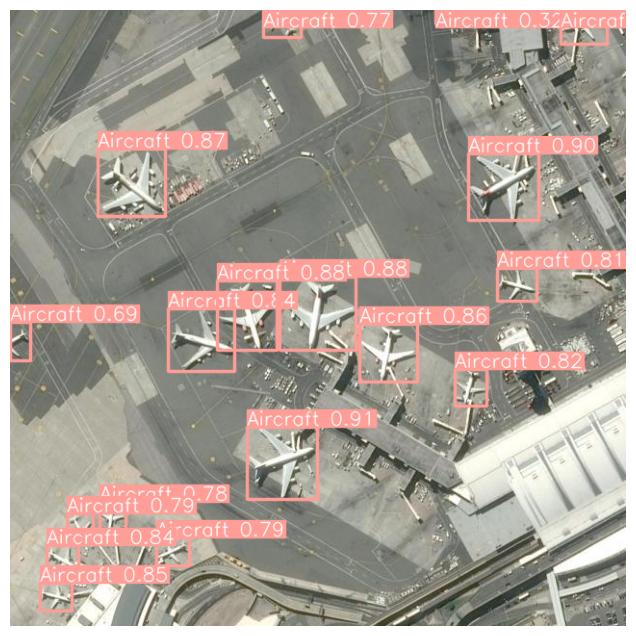

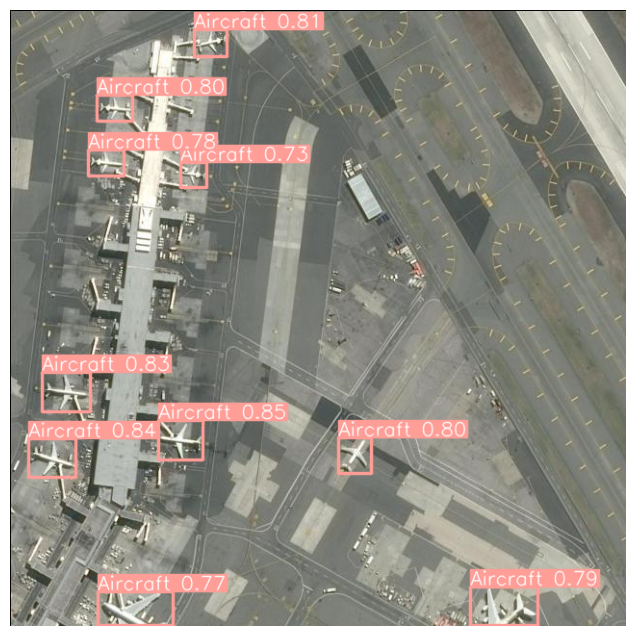

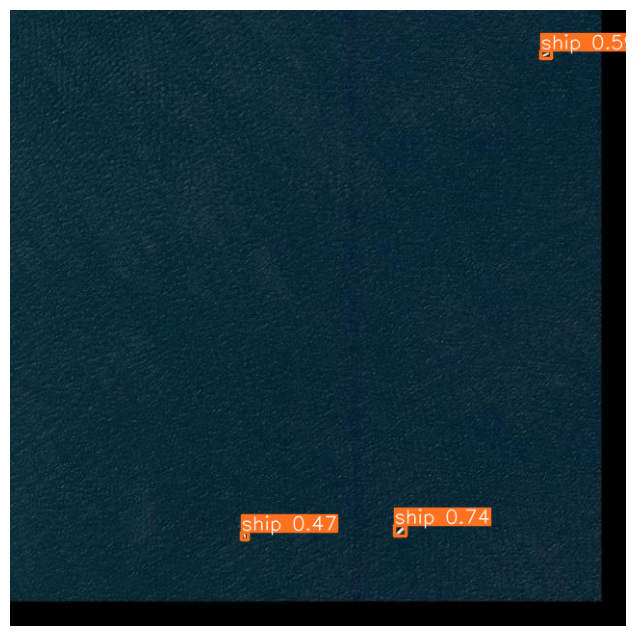

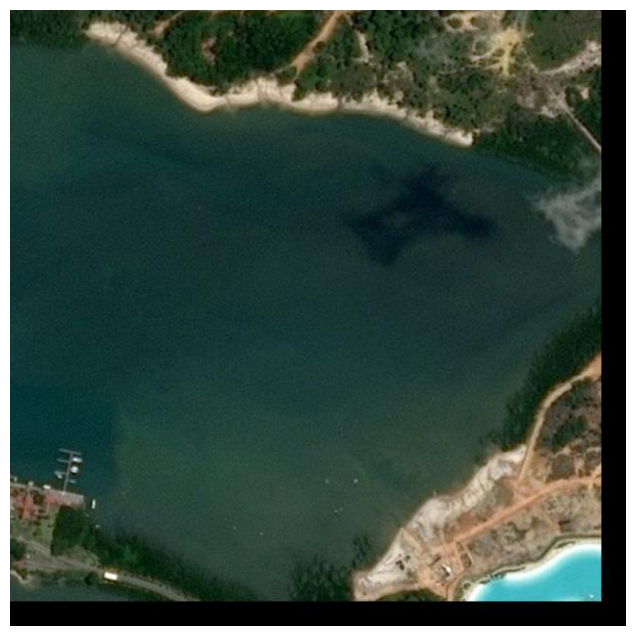

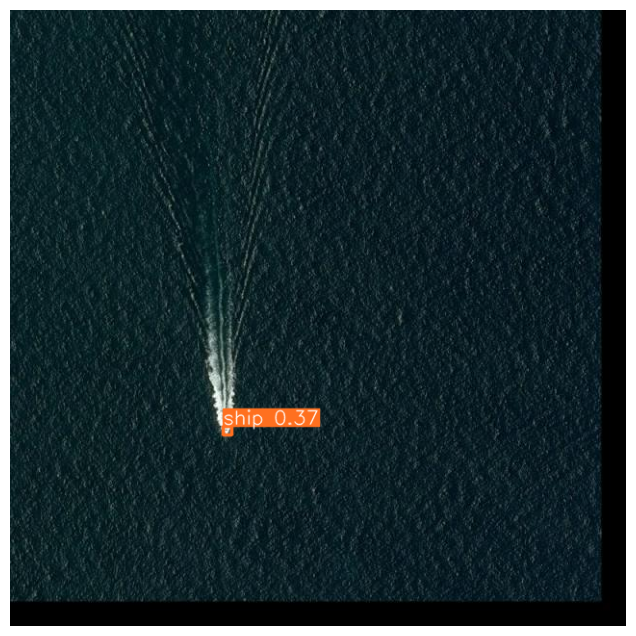

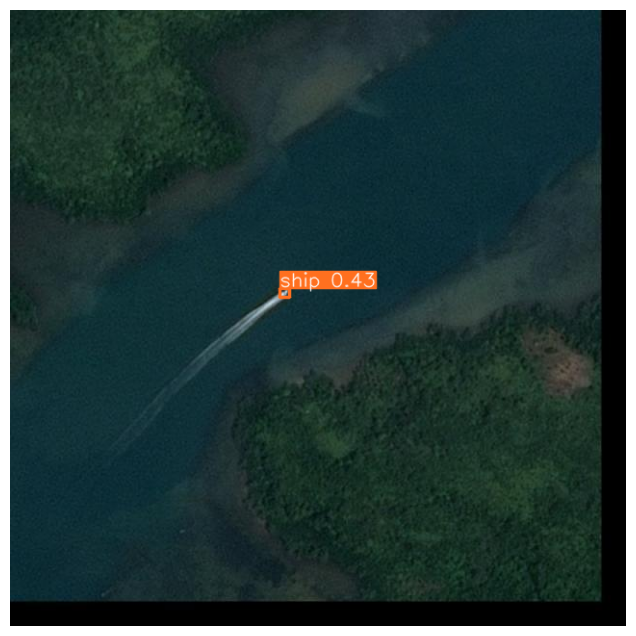

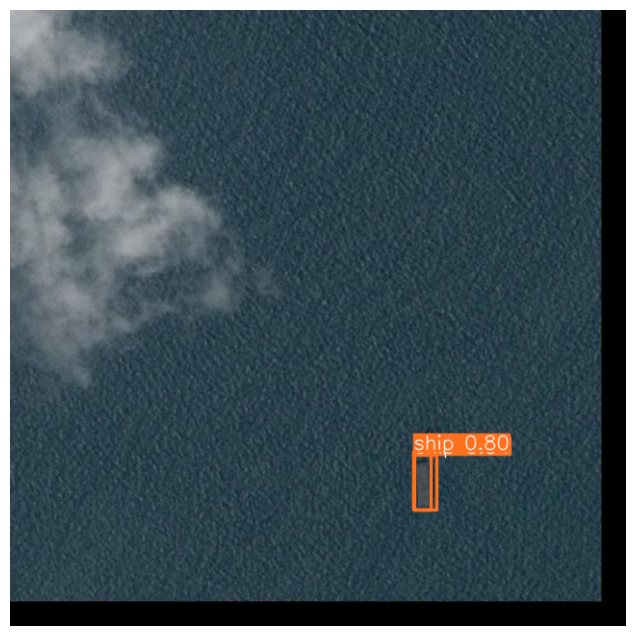

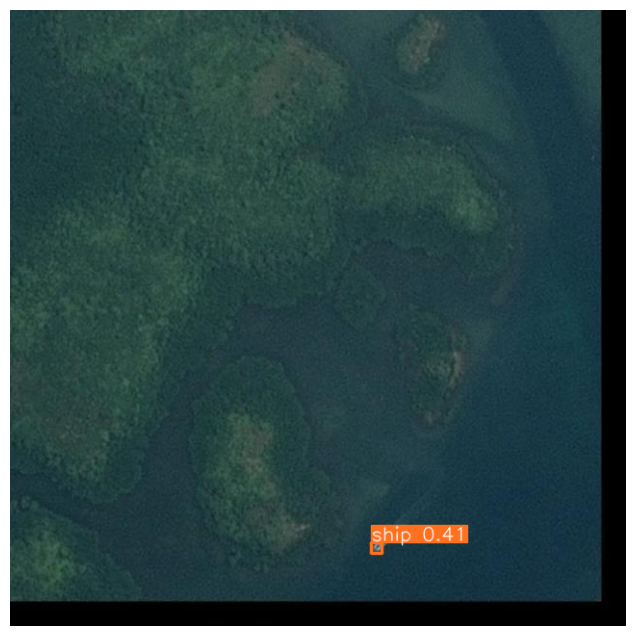

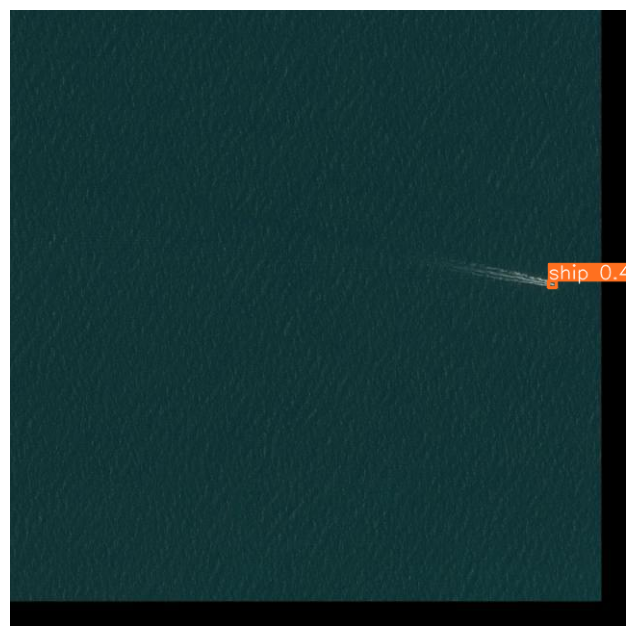

In [23]:
# Show some results
for k in range(len(results)):
    ph.show(results[k])

In [24]:
# The way to test the model is with the test dataset.

# Test the model with split='test'. Dataset and settings are remembered.
metrics = model.val(split='test')

print(metrics.box.map)    # map50-95
print(metrics.box.map50)  # map50
print(metrics.box.map75)  # map75
print(metrics.box.maps)   # a list contains map50-95 of each category

Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)


val: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache... 538 images, 0 backgrounds, 0 corrupt: 100%|██████████| 538/538 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]


                   all        538      11226       0.64      0.572      0.555      0.314
              Aircraft        538       2233      0.955       0.92      0.935      0.672
                  ship        538        364      0.475      0.407      0.365      0.142
               vehicle        538       8629       0.49      0.391      0.365      0.128
Speed: 0.8ms preprocess, 3.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\val
0.3138654644105579
0.5550576486716771
0.3201338380046543
[    0.31387     0.67222     0.14165     0.12773]


In [25]:
from sklearn.model_selection import KFold

In [26]:
model = YOLO('yolov8n.pt')

In [27]:
def kfold_cv(length, k, test_percent):
    """
    Generates indices for test data and k-fold cross validation on a dataset.

    Args:
    length (int): Total number of images in the dataset.
    k (int): Number of folds for k-fold cross validation.
    test_percent (float): Percentage of the dataset to be used for testing.

    Returns:
    tuple:
        - test_ids (list): A list of indices for test data.
        - kfold_generator (generator): A generator that yields training and
            validation indices for each fold.
    """
    # Calculate the number of test images
    num_test_images = int(length * test_percent / 100)

    # Randomly select test indices
    all_indices = np.arange(length)
    np.random.shuffle(all_indices)
    test_ids = list(all_indices[:num_test_images])

    # Remaining indices for k-fold
    remaining_indices = all_indices[num_test_images:]

    # K-Fold Cross Validation
    kf = KFold(n_splits=k)
    kfold_generator = ((list(remaining_indices[train_index]),
                        list(remaining_indices[val_index])) for train_index,
                        val_index in kf.split(remaining_indices))

    return test_ids, kfold_generator

In [28]:
def select_strings(strings, indices, pre='', post=''):
    """
    Selects and returns strings from a list based on a list of indices.

    Args:
    strings (list of str): The list of strings.
    indices (list of int): The list of indices to select strings.
    pre (string): String to add before the indexed string.
    post (string): String to add after the indexed string.

    Returns:
    list of str: The list of selected strings.

    Example:
    select_strings(['John', 'Tom', 'Jack', 'Sam'], [0, 3], pre='Hello ')
    >>> ['Hello John', 'Hello Sam']
    """
    return [pre + strings[i] + post for i in indices if i < len(strings)]

In [29]:
def create_text_file(strings, folder_path=None, file_name="output.txt"):
    """
    Creates a text file with each string from the list on a separate line
    in UTF-8 format.

    Args:
    strings (list of str): The list of strings to be written to the file.
    folder_path (str, optional): The path to the folder where the file will
        be saved. If not provided, the file is saved in the current directory.
    file_name (str, optional): The name of the file to be created. Defaults
        to 'output.txt'.
    """
    # If a folder path is provided, use it; otherwise, use the current
    # directory
    if folder_path:
        full_path = os.path.join(folder_path, file_name)
    else:
        full_path = file_name

    # Writing the strings to the file in UTF-8 format
    with open(full_path, 'w', encoding='utf-8') as file:
        for string in strings:
            file.write(string + '\n')

In [30]:
# Before executing next cell make sure you have your file
# 'dataset_mask_2.yaml' properly configured. Specifically, it must
# point to the files `test.txt`, `val.txt` and `train.txt`.

# Get the dataset folder
dataset_path = os.path.join(PROJECT_DIR, 'dataE1')

# List all image files
all_files = [f for f in ph.list_files_in_folder(dataset_path,
    absolute=True, recursivity=True) if str(f).endswith('.jpg')]

# Select parameters in k-fold cross validation
k = 8
test_percent = 18  # Percentage of data for testing
test_ids, kfold_gen = kfold_cv(len(all_files), k, test_percent)

# Get paths list for testing and create text file
test_paths = select_strings(all_files, test_ids)
create_text_file(test_paths, dataset_path, 'test.txt')

In [31]:
# Train the models
metric = []
for train_ids, val_ids in kfold_gen:
    # Get training and validation images paths
    train_paths = select_strings(all_files, train_ids)
    val_paths = select_strings(all_files, val_ids)

    # Create text files with the lists of images paths
    create_text_file(train_paths, dataset_path, 'train.txt')
    create_text_file(val_paths, dataset_path, 'val.txt')

    # Train the model
    model.train(data='dataset_sky_2.yaml', epochs=5, resume=False)
    metric.append(model.metrics.results_dict['metrics/mAP50(B)'])

New https://pypi.org/project/ultralytics/8.2.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset_sky_2.yaml, epochs=5, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

train: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 2147 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2147/2147 [00:01<00:00, 1725.17it/s]


train: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache


val: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<00:00, 987.61it/s]


val: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache
Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.02G      2.088      2.349      1.132        130        640: 100%|██████████| 135/135 [00:30<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]

                   all        307       5574       0.61       0.33      0.363      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       5.7G      1.841      1.334      1.027         38        640: 100%|██████████| 135/135 [00:20<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]

                   all        307       5574      0.453      0.434      0.412      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.3G      1.807      1.216      1.015        648        640: 100%|██████████| 135/135 [00:26<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

                   all        307       5574      0.558       0.46      0.446      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.11G      1.737      1.078      1.001         37        640: 100%|██████████| 135/135 [00:20<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]

                   all        307       5574       0.57      0.478      0.461      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.46G      1.731       1.06     0.9786         66        640: 100%|██████████| 135/135 [00:44<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.98s/it]

                   all        307       5574      0.565      0.509      0.484      0.264



5 epochs completed in 0.061 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


                   all        307       5574      0.566      0.509      0.484      0.264
              Aircraft        307       1437      0.845      0.939       0.94      0.623
                  ship        307        186      0.384      0.339      0.263      0.096
               vehicle        307       3951       0.47      0.249      0.249      0.074
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train2
New https://pypi.org/project/ultralytics/8.2.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset_sky_2.yaml, epochs=5, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministi

train: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 2147 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2147/2147 [00:01<00:00, 2132.15it/s]


train: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache


val: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<00:00, 1026.17it/s]


val: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache
Plotting labels to runs\detect\train22\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.95G      1.723      1.022     0.9817         54        640: 100%|██████████| 135/135 [00:26<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.98s/it]

                   all        307       6539      0.605      0.493      0.483       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       7.3G      1.653     0.9786     0.9829         75        640: 100%|██████████| 135/135 [00:19<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]

                   all        307       6539      0.541      0.468      0.453      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.2G      1.733      1.007     0.9834         23        640: 100%|██████████| 135/135 [00:27<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

                   all        307       6539      0.568      0.509      0.469      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.2G      1.643      0.917      0.977         78        640: 100%|██████████| 135/135 [00:20<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]

                   all        307       6539      0.557      0.509      0.485       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.19G       1.63     0.8999     0.9702         33        640: 100%|██████████| 135/135 [00:20<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]

                   all        307       6539      0.619      0.499      0.508      0.285



5 epochs completed in 0.059 hours.
Optimizer stripped from runs\detect\train22\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train22\weights\best.pt, 6.2MB

Validating runs\detect\train22\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


                   all        307       6539      0.618      0.499      0.508      0.285
              Aircraft        307       1306      0.899      0.894      0.898      0.624
                  ship        307        264      0.434      0.311      0.292      0.116
               vehicle        307       4969      0.521      0.293      0.334      0.114
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train22
New https://pypi.org/project/ultralytics/8.2.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset_sky_2.yaml, epochs=5, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, determinis

train: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 2147 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2147/2147 [00:01<00:00, 2078.70it/s]


train: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache


val: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<00:00, 967.41it/s]


val: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache
Plotting labels to runs\detect\train222\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.36G      1.625     0.8927     0.9596        121        640: 100%|██████████| 135/135 [00:23<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]

                   all        307       6823      0.642      0.558      0.565       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5        11G      1.675     0.9345     0.9735        121        640: 100%|██████████| 135/135 [00:27<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]

                   all        307       6823       0.64      0.562       0.56      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.42G      1.654     0.9173     0.9709        779        640: 100%|██████████| 135/135 [00:21<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]

                   all        307       6823      0.601      0.543      0.536      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       9.2G       1.63     0.8689     0.9672        125        640: 100%|██████████| 135/135 [00:23<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]

                   all        307       6823      0.629      0.539      0.549        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      10.4G      1.646     0.8839      0.961         26        640: 100%|██████████| 135/135 [00:28<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

                   all        307       6823      0.663      0.586      0.586      0.317



5 epochs completed in 0.062 hours.
Optimizer stripped from runs\detect\train222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train222\weights\best.pt, 6.2MB

Validating runs\detect\train222\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


                   all        307       6823      0.665      0.586      0.587      0.317
              Aircraft        307       1336      0.906      0.955      0.962      0.672
                  ship        307        218      0.655      0.381      0.441      0.156
               vehicle        307       5269      0.434      0.423      0.357      0.121
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train222
New https://pypi.org/project/ultralytics/8.2.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset_sky_2.yaml, epochs=5, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, determin

train: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 2147 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2147/2147 [00:01<00:00, 2086.23it/s]


train: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache


val: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<00:00, 940.03it/s]


val: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache
Plotting labels to runs\detect\train2222\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.45G      1.577     0.8346     0.9553        178        640: 100%|██████████| 135/135 [00:21<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:29<00:00,  2.98s/it]

                   all        307       7392      0.627      0.554      0.546      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      10.6G      1.602     0.8528     0.9634         77        640: 100%|██████████| 135/135 [00:28<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.09s/it]

                   all        307       7392      0.661      0.539      0.545      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      11.4G      1.634     0.8686     0.9644         30        640: 100%|██████████| 135/135 [00:31<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

                   all        307       7392      0.608      0.562      0.532      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.17G      1.557     0.8217     0.9626         17        640: 100%|██████████| 135/135 [00:20<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:33<00:00,  3.36s/it]

                   all        307       7392      0.657      0.561      0.557       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.87G      1.589     0.8338      0.956         15        640: 100%|██████████| 135/135 [00:22<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:32<00:00,  3.23s/it]

                   all        307       7392      0.638      0.564      0.558      0.307



5 epochs completed in 0.074 hours.
Optimizer stripped from runs\detect\train2222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2222\weights\best.pt, 6.2MB

Validating runs\detect\train2222\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


                   all        307       7392      0.657      0.561      0.556      0.309
              Aircraft        307       1240      0.909      0.919      0.933       0.65
                  ship        307        211        0.6      0.427      0.435      0.179
               vehicle        307       5941      0.463      0.338        0.3     0.0991
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train2222
New https://pypi.org/project/ultralytics/8.2.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset_sky_2.yaml, epochs=5, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, determ

train: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 2147 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2147/2147 [00:01<00:00, 2108.74it/s]


train: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache


val: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<00:00, 976.14it/s] 


val: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache
Plotting labels to runs\detect\train22222\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.94G      1.579     0.8308     0.9504         95        640: 100%|██████████| 135/135 [00:22<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

                   all        307       6977      0.602      0.606      0.582      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.22G      1.593     0.8462      0.958        141        640: 100%|██████████| 135/135 [00:19<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]

                   all        307       6977      0.655      0.585      0.579      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.47G      1.602     0.8506     0.9582         28        640: 100%|██████████| 135/135 [00:25<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]

                   all        307       6977      0.581       0.53      0.519       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.59G      1.585     0.8211     0.9571         16        640: 100%|██████████| 135/135 [00:19<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

                   all        307       6977      0.652      0.606      0.602      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.87G      1.577     0.8209     0.9533         27        640: 100%|██████████| 135/135 [00:19<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]

                   all        307       6977       0.62       0.61      0.578      0.316



5 epochs completed in 0.043 hours.
Optimizer stripped from runs\detect\train22222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train22222\weights\best.pt, 6.2MB

Validating runs\detect\train22222\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


                   all        307       6977      0.653      0.607      0.602      0.325
              Aircraft        307       1460      0.907      0.942      0.943      0.672
                  ship        307        180      0.577      0.477       0.49      0.185
               vehicle        307       5337      0.475      0.403      0.373      0.119
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train22222
New https://pypi.org/project/ultralytics/8.2.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset_sky_2.yaml, epochs=5, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, dete

train: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 2147 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2147/2147 [00:01<00:00, 2074.54it/s]


train: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache


val: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<00:00, 1145.83it/s]


val: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache
Plotting labels to runs\detect\train222222\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.06G      1.522     0.8029     0.9471         59        640: 100%|██████████| 135/135 [00:21<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]

                   all        307       6289      0.576      0.514      0.503       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      6.76G      1.589     0.8433     0.9577        228        640: 100%|██████████| 135/135 [00:20<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]

                   all        307       6289      0.555      0.524      0.483      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.5G      1.566     0.8293     0.9566        196        640: 100%|██████████| 135/135 [00:28<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

                   all        307       6289      0.555      0.499      0.486      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.26G      1.535     0.7875     0.9516         15        640: 100%|██████████| 135/135 [00:20<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]

                   all        307       6289      0.611      0.535      0.507      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.74G      1.534      0.781     0.9481         19        640: 100%|██████████| 135/135 [00:29<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]

                   all        307       6289      0.604      0.519      0.514      0.292



5 epochs completed in 0.086 hours.
Optimizer stripped from runs\detect\train222222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train222222\weights\best.pt, 6.2MB

Validating runs\detect\train222222\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


                   all        307       6289      0.604      0.519      0.514      0.292
              Aircraft        307       1098      0.929      0.942      0.951      0.685
                  ship        307        309      0.463      0.243      0.263     0.0902
               vehicle        307       4882      0.419      0.372      0.329      0.101
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train222222
New https://pypi.org/project/ultralytics/8.2.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset_sky_2.yaml, epochs=5, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2222222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, de

train: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 2148 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2148/2148 [00:01<00:00, 2113.34it/s]


train: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache


val: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 306 images, 0 backgrounds, 0 corrupt: 100%|██████████| 306/306 [00:00<00:00, 897.08it/s]


val: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache
Plotting labels to runs\detect\train2222222\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.99G      1.464      0.754     0.9484         67        640: 100%|██████████| 135/135 [00:21<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:38<00:00,  3.85s/it]

                   all        306       8067      0.584      0.541      0.509      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.92G      1.524      0.788     0.9468        197        640: 100%|██████████| 135/135 [00:27<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:38<00:00,  3.83s/it]

                   all        306       8067      0.568      0.502      0.493      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.95G       1.54     0.8014     0.9566         92        640: 100%|██████████| 135/135 [00:19<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.06s/it]

                   all        306       8067      0.583      0.543      0.509       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.67G      1.525     0.7812     0.9542         23        640: 100%|██████████| 135/135 [00:19<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.07s/it]

                   all        306       8067      0.574       0.53      0.496      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.39G      1.519     0.7685     0.9422         63        640: 100%|██████████| 135/135 [00:19<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.07s/it]

                   all        306       8067      0.622      0.526      0.518      0.294



5 epochs completed in 0.112 hours.
Optimizer stripped from runs\detect\train2222222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2222222\weights\best.pt, 6.2MB

Validating runs\detect\train2222222\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


                   all        306       8067      0.622      0.526      0.519      0.294
              Aircraft        306       1176      0.929       0.96      0.964      0.675
                  ship        306        205      0.514      0.302      0.333      0.128
               vehicle        306       6686      0.422      0.317      0.259     0.0801
Speed: 0.4ms preprocess, 2.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train2222222
New https://pypi.org/project/ultralytics/8.2.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset_sky_2.yaml, epochs=5, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22222222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, 

train: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 2148 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2148/2148 [00:01<00:00, 2073.03it/s]


train: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache


val: Scanning C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels... 306 images, 0 backgrounds, 0 corrupt: 100%|██████████| 306/306 [00:00<00:00, 1111.02it/s]


val: New cache created: C:\Users\jaadn\OneDrive\Escritorio\SI UIB\2nd Semester\Deep Learning\Labs\FINAL LAB\dataE1\test\labels.cache
Plotting labels to runs\detect\train22222222\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.82G      1.507     0.7746     0.9436        145        640: 100%|██████████| 135/135 [00:21<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:12<00:00,  1.30s/it]

                   all        306       5858      0.635      0.548      0.546      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      11.6G      1.521     0.7769     0.9415        247        640: 100%|██████████| 135/135 [00:33<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]

                   all        306       5858      0.599       0.52       0.52      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.41G      1.564     0.7951     0.9447        167        640: 100%|██████████| 135/135 [00:21<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

                   all        306       5858      0.576      0.541      0.528      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.14G      1.538     0.7801     0.9603          7        640: 100%|██████████| 135/135 [00:19<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]

                   all        306       5858       0.65      0.575      0.566      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.08G      1.525     0.7551     0.9349        157        640: 100%|██████████| 135/135 [00:57<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]

                   all        306       5858      0.654      0.584      0.583       0.32



5 epochs completed in 0.064 hours.
Optimizer stripped from runs\detect\train22222222\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train22222222\weights\best.pt, 6.2MB

Validating runs\detect\train22222222\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.11 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


                   all        306       5858      0.653      0.583      0.583       0.32
              Aircraft        306       1274      0.959      0.945      0.959      0.683
                  ship        306        187       0.54      0.406       0.43      0.158
               vehicle        306       4397      0.459      0.398       0.36      0.119
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train22222222


In [32]:
# See the reported metric of each model
print(f'Metric mAP50: {metric}')

# See the average:
print(f'Average of all mAP50: {np.mean(metric)}')

Metric mAP50: [0.4839882315354789, 0.5079183423239135, 0.5868495145239202, 0.5562793685146808, 0.6020185444188463, 0.5142709138924038, 0.5185606623130651, 0.5829772445988382]
Average of all mAP50: 0.5441078527651433


## EXERCISE 2

In the original notebook, all the necessary components to develop a .py file with the squat counter are included. Observe the detail of how this program performs the said calculation, how it evaluates whether the person is standing or squatting, and how it prevents oscillations.

The objective of this exercise is to modify the program so that it counts squats in three different modes. In the first mode, it should count them as it is done in the original. In the second mode, it should count them only and exclusively if the hands are above the hips throughout the entire squat. In the third mode, it will be the same as the second, but with the hands above the shoulders.

The counting mode should appear on the screen (mode 1, 2, or 3), and each time a squat is performed and it is not correct according to the mode, a message should appear on the screen that says "bad squatting."

Remember that you'll run the script on yourt laptop in the presentation using a the camera and/or a video.

# PRESENTATION

You **don't** have to prepare any presentation but the code.

The presentation will be done directly over the jupyter notebook (exercise 1) and the script and it's execution (exercise 2).

You will have to explain some parts of the code and/or the results displayed by the code (plots, metrics, ...) as a demonstration that you know what it does and how.

Enjoy it!